-----

# What is `PSI`?

In traditional cosmological N-body simulations, the dark matter mass is discretized into point particles. This leads to numerical artifacts arising from two-body interactions and artificial fragmentation of cosmic web filaments into low-mass haloes ([Hahn et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.434.1171H/abstract)). Furthermore, analyzing the outputs of these simulations is problematic because it is difficult to construct a continuous density field. [Abel et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427...61A/abstract) introduced the Phase Space Sheet discretization, in which N-body particles are re-interpreted as tracers of a cold fluid in phase space, and the mass is instead interpolated *between* the particle positions. This approach was very successful in reducing particle noise in simulations, allowing for analyses of the warm dark matter halo mass function (e.g. [Angulo et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.434.3337A/abstract)), cosmic velocity fields ([Hahn et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.454.3920H/abstract)), and cosmic voids ([Wojtak et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.458.4431W/abstract)), without the numerical artifacts inherent to the particle discretization.

`PSI` (the Phase Space Intersector) is a post-processing tool for the outputs of cosmological simulations. `PSI` applies the Phase Space Sheet discretization to a set of particles, and then volume-samples the density and velocity fields (as well as higher-order moments) onto a Cartesian grid. Anyone can use `PSI` to produce smooth and continuous density and velocity maps from particle data!  The volume-sampling procedure is geometrically exact, and converves mass down to machine precision. For more details on the inner workings of `PSI`, see [Powell & Abel (2015)](http://www.sciencedirect.com/science/article/pii/S0021999115003563) and [LA-UR-15-26964](https://github.com/devonmpowell/r3d/blob/master/la-ur-15-26964.pdf). 

To load `PSI`, just `import` the Python module. 
We will also include `helpers`, which just contains some auxiliary data and a plotting routine to make these examples less cluttered, as well as `numpy`.

-----

In [2]:
import PSI as psi
import helpers as hlp
import numpy as np

-----
## Example 1: Voxelizing individual mass elements

At its core, `PSI` voxelizes tetrahedra. This means that `PSI` computes the exact geometric intersection between a tetrahedral mass element and each underlying grid cell (voxel), and determines how much mass lies in each one.  `PSI` also computes higher-order moments like mean velocity (interpolated from the vertices) and position (containing information on density gradients within a cell).

Usually, tetrahedral Lagrangian meshes are not as common as meshes with a Cartesian topology. This is the case in many cosmological simulations, where the initial conditions are comprised of particles in a slightly-perturbed grid arrangement.  For this reason, `PSI` includes logically cubic mesh elements with trilinear and triquadratic interpolation. These elements are adaptively refined into tetrahedra to approximate a curvilinear mass mapping to the desired precision.

In this first example, we will voxelize individual mass elements to demonstrate the basic function of `PSI`.

- First, we create a grid using `PSI.Grid()`. `n` is a 3-tuple specifiying the number of grid cells in each direction. `bounds` is a pair of 3-tuples containing the physical coordinates of the lower-left and upper-right corners of the grid. In this example, we use a unit cube.

- Next, we create a mass element using `PSI.Mesh()`. For this example, we use `loader='array'` to provide an explicit array of positions (`pos`) and vertex indices (`connectivity`). 

- Finally, we call `PSI.voxels()`, the core function in `PSI`. We provide `grid` and `mesh` as arguments. Additionally, we give the arguments `refine_tolerance` (the maximum positional error allowed in the curvilinear interpolation, in units of grid cells) and `refine_max_lvl` (the maximum number of refinement splits allowed, where `0` completely disables refinement).

- The result of `PSI.voxels()` is placed in `grid.fields['m']`. This is an array containing the mass in each grid cell. We can compare the total gridded mass to `mesh.mass` to see that `PSI` conserves mass to within machine precision.  We also plot the density as both a slice and a projection of the 3D grid.

-----

Tetrahedron: 4 vertices per element
Element 1 of 1, 100.0%
Global error = 2.220446e-16

Trilinear: 8 vertices per element
Element 1 of 1, 100.0%
Global error = 1.110223e-16

Triquadratic: 27 vertices per element
Element 1 of 1, 100.0%
Global error = 1.110223e-16



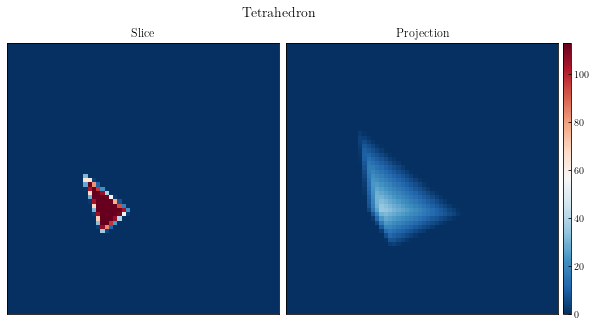

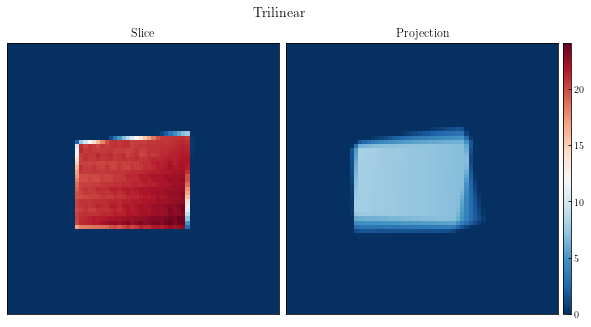

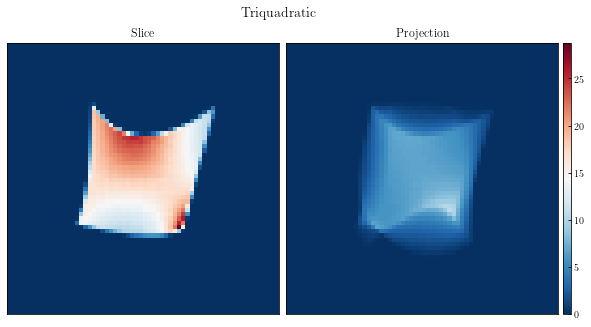

In [3]:

# do all three element types
for order, label in enumerate(['Tetrahedron', 'Trilinear', 'Triquadratic']):
    
    # create the Grid, specifying the resolution and projection window
    ngrid = 64
    grid = psi.Grid(n=3*(ngrid,), bounds=(3*(0.,),3*(1.,)))

    # retrieve positions and vertex connectivity of a unit element
    pos = hlp.unit_elements_pos[order].copy()
    conn = hlp.unit_elements_conn[order].copy()

    # perturb the position randomly, keeping it within the unit box
    pos -= 0.5
    pos *= 0.2 + 0.4*np.random.uniform(size=pos.shape)
    pos += 0.5
    
    print(f'{label}: {pos.shape[0]} vertices per element')

    # make a mesh, using the direct array input mode
    mesh = psi.Mesh(loader='array', pos=pos, connectivity=conn)

    # call PSI.voxels()
    psi.voxels(grid=grid, mesh=mesh, refine_tolerance=0.05, refine_max_lvl=10)

    # print the error 
    err = np.abs(1.0-np.sum(grid.fields['m'])/np.sum(mesh.mass))
    print(f'Global error = {err:5e}\n')

    # show a slice and projection
    rho = grid.fields['m']/np.product(grid.d)
    hlp.plot_twopanel_with_cb(rho[ngrid//2,:,:], np.average(rho, axis=0), title=label);


-----
## Example 2: A cosmological simulation box

Now that we understand how `PSI` handles individual mass elements, let's apply it to the case of computing the continuous density field from a set of discrete particles in a cosmological simulation.

- We again create a `Mesh` object. This time, however, we use `loader=gadget2` to create the mesh from the output of a cosmological simulation run using the `gadget2` code. `mesh` now contains the positions of the particles (which are treated as tracers of a Lagrangian mass sheet), as well as their velocities. The `gadget2` loader generates a mesh of trilinear elements, with sets of 8 particles connected according to their neighbors in the initial conditions. The mass is interpolated *between* particle positions. `mesh` also contains the field `wrapbox`, which are the boundaries of the (periodic) simulation box.

- We create a `PSI.Grid` as before, but with a couple of additions. First, we have used `mesh.wrapbox` to specify that the grid bounds should contain the entire simulation volume. We have also given `fields=['v','vv']`. This means that in addition to `grid.fields['m']`, `grid.fields` will also contain higher-order moments. `'v'` is the mean velocity, and `'vv'` is the velocity dispersion tensor.  

- `fields` can also accept `'x'` (the center of mass in each cell),`'xv'`, which is the position-velocity covariance in each cell (encoding velocity gradient information), and `'xx'`, which is the position-position covariance (or "shape") of the mass within each cell. There not yet an example for `'x'`, `'xv'`, and `'xx'` in this tutorial, but we encourage you to play with them!

- Finally, we call `PSI.voxels()` as before. Because `mesh` contains a `wrapbox`, `PSI.voxels()` will automatically wrap mass elements around the edges of the `grid`. 

-----

In [4]:
# load the mesh from a Gadget snapshot
snap = 'snapshot_010'
mesh = psi.Mesh(filename=snap, loader='gadget2')

# create the Grid, specifying the resolution and projection window
ngrid = 128
grid = psi.Grid(n=3*(ngrid,), bounds=mesh.wrapbox, fields=['v','vv'])

# call PSI.voxels()
psi.voxels(grid=grid, mesh=mesh, refine_max_lvl=2, refine_tolerance=0.1)

# check the total mass
err = np.abs(1.0-np.sum(grid.fields['m'])/np.sum(mesh.mass))
print('Global error = %.10e' % err)


Using the Gadget2 loader.
Loading snapshot_010...
...done.
Element 32768 of 32768, 100.0%
Global error = 6.9944050551e-15


-----
### Now let's make some plots!

We'll plot `rho`, the mass density. Because `grid.fields['m']` contains the total mass in each cell, we must divide by the cell volume, `np.product(grid.d)`.

We also plot `vy`, the y-component of the velocity, and `sigv`, the isotropized velocity dispersion (we use the determinant to turn the 3D tensor into a scalar value).

In the mass density plot, we can see the individual trilinear elements in low-density regions where there are very few particles. Despite this being a very low-resolution simulation containing only 32<sup>3</sup> particles, we get very nice continuous density and velocity fields. This is what `PSI` is all about!

-----

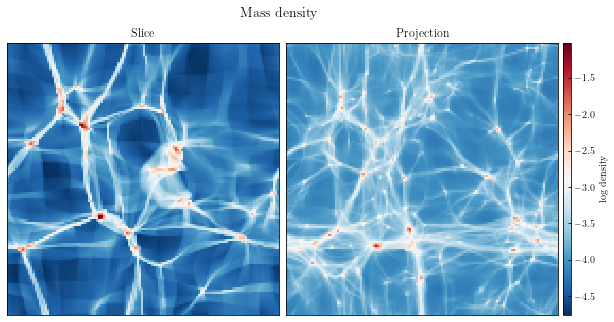

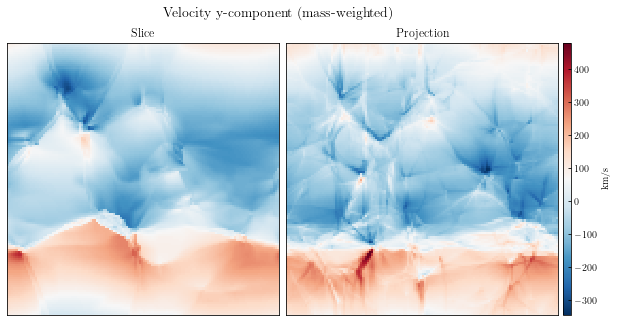

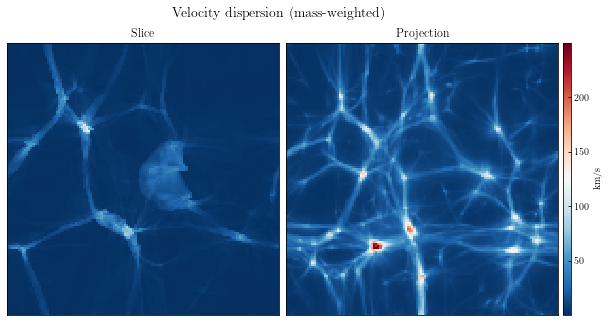

In [5]:
# get gridded quantities from grid.fields
rho = grid.fields['m']/np.product(grid.d)
vy = grid.fields['v'][...,1]
sigv = np.linalg.det(grid.fields['vv'])**(1/6)

# mass density
hlp.plot_twopanel_with_cb(np.log10(rho[ngrid//2,:,:]), np.log10(np.average(rho, axis=0)), 
                          title='Mass density', units='log density');
# mean velocity
hlp.plot_twopanel_with_cb(vy[ngrid//2,:,:], np.average(vy, weights=rho, axis=0), 
                          title='Velocity y-component (mass-weighted)', units='km/s');
# velocity dispersion
hlp.plot_twopanel_with_cb(sigv[ngrid//2,:,:], np.average(sigv, weights=rho, axis=0), 
                          title='Velocity dispersion (mass-weighted)', units='km/s');

-----
## Example 3: Zooming in

As a second example with the cosmological simulation, let's run `PSI.voxels`, but with a grid zoomed in on the most massive object in the simulation.

We use some numpy trickery to get the coordinate of the center of the densest cell from Example 2. We create a zoomed-in window around it and pass it to `psi.Grid`, then we run `PSI.voxels` and make our plots as before.

-----

In [6]:
# Get the location of the maximum density and zoom in around it
maxind = np.unravel_index(grid.fields['m'].argmax(), grid.fields['m'].shape)
center = (0.5+np.array(maxind))*np.array(grid.d)
wmin = center - 5.0
wmax = center + 5.0

# Make a zoomed-in grid and run voxels() again
grid_zoom = psi.Grid(type='cart', n=3*(ngrid,), bounds=(wmin, wmax), fields=['v','vv'])
psi.voxels(grid=grid_zoom, mesh=mesh, refine_max_lvl=2, refine_tolerance=0.1)

Element 32768 of 32768, 100.0%


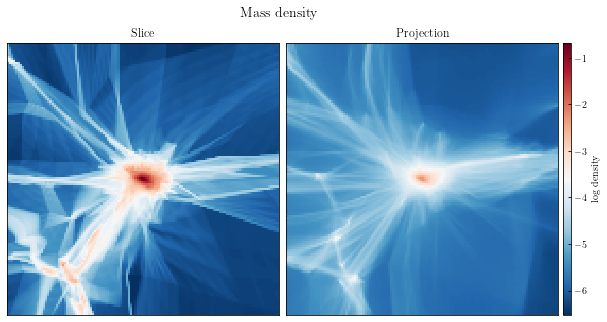

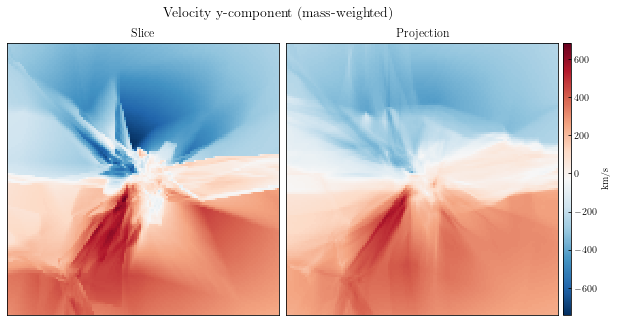

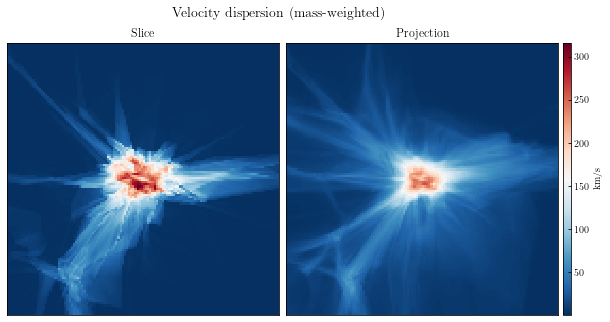

In [7]:
# get gridded quantities from grid.fields
rho = grid_zoom.fields['m']/np.product(grid.d) # mass density
vy = grid_zoom.fields['v'][...,1] # mean velocity
sigv = np.linalg.det(grid_zoom.fields['vv'])**(1/6) # velocity dispersion

# mass density
hlp.plot_twopanel_with_cb(np.log10(rho[ngrid//2,:,:]), np.log10(np.average(rho, axis=0)), 
                          title='Mass density', units='log density');
# mean velocity
hlp.plot_twopanel_with_cb(vy[ngrid//2,:,:], np.average(vy, weights=rho, axis=0), 
                          title='Velocity y-component (mass-weighted)', units='km/s');
# velocity dispersion
hlp.plot_twopanel_with_cb(sigv[ngrid//2,:,:], np.average(sigv, weights=rho, axis=0), 
                          title='Velocity dispersion (mass-weighted)', units='km/s');

-----
## Example 4: Custom meshes using the `block` loader

The only built-in support for loading cosmological simulation snapshots with `PSI.Mesh()` is for `gadget2` and `gevolution`. Obviously, there are many other simulation codes out there! For this reason, `PSI.Mesh()` also supports `loader='block'`, which accepts a logically-Cartesian array of particle positions (and masses and velocities) as `numpy` arrays. Any cosmological simulation whose particles are ordered in a Cartesian grid in the initial conditions can be passed to `PSI` this way, after being loaded into Python using the parser of your choosing.

In this example, we will generate a set of particle positions and perturb them to make an interesting density map.

- First, we create a Cartesian grid of particle positions within the unit cube. They should be in a C-style ordering, so that the z-coordinate changes the fastest. We use `numpy.mgrid` followed by some axis manipulation to achieve this.

- We perturb the particle positions using `sin` and `cos` (a plane wave).

- We make a `PSI.Mesh` from the particle positions. You can optionally supply arrays for the particle masses and velocities, but we don't need them for this example. We make the mesh periodic within the unit cube.

- The rest is the same as before! In the plot, you can see how perturbing the (Lagrangian) particle positions has resulted in a change to the mass density.

-----

Element 262144 of 262144, 100.0%
Global error = 0.0000000000e+00


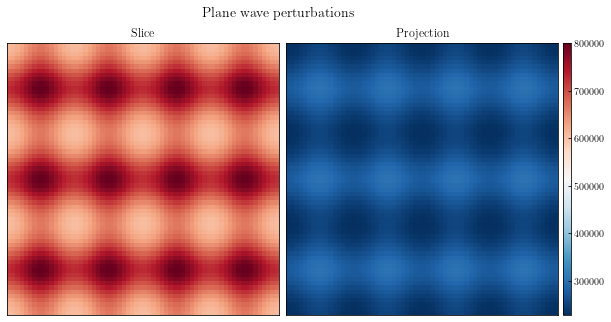

In [8]:
# create a grid of particle positions and perturb them to make a non-uniform density
nside = 64
gtmp = np.mgrid[:nside,:nside,:nside]
pos = (np.rollaxis(gtmp,0,4).copy() + 0.5)/nside
pos[...,0] += 0.1*np.sin(2*np.pi*pos[...,0])
pos[...,1] += 0.005*np.sin(6*np.pi*pos[...,1])
pos[...,2] += 0.002*np.sin(8*np.pi*pos[...,2])

# make a mesh, make it periodic
box = (3*(0.,),3*(1.,))
mesh = psi.Mesh(loader='block', pos=pos, periodic_box=box)

# create the Grid
ngrid = 64
grid = psi.Grid(n=3*(ngrid,), bounds=box)

# call PSI.voxels()
psi.voxels(grid=grid, mesh=mesh, refine_tolerance=0.05, refine_max_lvl=2)

# check the total mass
err = np.abs(1.0-np.sum(grid.fields["m"])/np.sum(mesh.mass))
print('Global error = %.10e' % err)


# show a slice and projection
rho = grid.fields['m']/np.product(grid.d)
hlp.plot_twopanel_with_cb(rho[ngrid//2,:,:], np.average(rho, axis=0), title='Plane wave perturbations');

-----
## Additional notes

- The `PSI.Mesh()` constructor always requires the particle positions `pos`. `vel` and `mass` are optional. If `vel` is missing, all velocities will be zero. The default `mass` is 1.0 for every particle.

- As you might expect, larger `n` in `PSI.Grid` and more particles in `PSI.Mesh` will cause `PSI.voxels()` to need more compute time.

- Likewise, a larger `refine_max_lvl` and/or smaller `refine_tolerance` will use more compute time.

- If you just want a 2D projection through a 3D box, just create a grid with `n=(nx,ny,1)` or similar -- it will be much faster than running `PSI.voxels()` on a 3D grid and then summing over one axis.

-----

